# Stock Trading with Technical Indicators


# 1.0 Setup

## 1.1 Install library

Package required
- yfinance

In [1]:
# Uncomment to install required package
# !pip install yfinance

## 1.2 Import library

In [2]:
# System
import datetime as dt
from functools import partial

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

# Source
import yfinance as yf

In [3]:
# Not showing pandas future depreciation warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.3 Define parameter

In [4]:
visa_ticker = 'V'
t_bill_ticker = '^TNX'

In [5]:
TRADING_DAYS = 252

LONG_POSITION = 1
SHORT_POSITION = -1

In [6]:
beg_dt = dt.datetime(2017, 1, 1)
end_dt = dt.datetime(2022, 12, 31)

## 1.4 Fetch dataset

In [7]:
fetch_data = partial(yf.download, start=beg_dt, end=end_dt)

In [8]:
visa = fetch_data(visa_ticker)
rfr = fetch_data(t_bill_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 2.0 Overview

In [9]:
visa.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,78.760002,79.910004,78.489998,79.500000,76.391365,13785200
2017-01-04 00:00:00-05:00,79.440002,80.260002,79.360001,80.150002,77.015945,8033100
2017-01-05 00:00:00-05:00,80.339996,81.529999,80.220001,81.089996,77.919189,7805100
2017-01-06 00:00:00-05:00,81.300003,82.489998,80.940002,82.209999,78.995399,8898300
2017-01-09 00:00:00-05:00,82.279999,82.449997,81.650002,81.750000,78.553391,7305300


In [10]:
visa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1510 non-null   float64
 1   High       1510 non-null   float64
 2   Low        1510 non-null   float64
 3   Close      1510 non-null   float64
 4   Adj Close  1510 non-null   float64
 5   Volume     1510 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.6 KB


In [11]:
visa.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1510.0,1.701100e+02,4.520849e+01,7.876000e+01,1.331300e+02,1.801300e+02,2.083650e+02,2.500500e+02
High,1510.0,1.717548e+02,4.577593e+01,7.991000e+01,1.344550e+02,1.816650e+02,2.105150e+02,2.526700e+02
Low,1510.0,1.684310e+02,4.463944e+01,7.849000e+01,1.318075e+02,1.788400e+02,2.061975e+02,2.482200e+02
Close,1510.0,1.701087e+02,4.517110e+01,7.950000e+01,1.331250e+02,1.800350e+02,2.081575e+02,2.509300e+02
Adj Close,1510.0,1.672103e+02,4.580586e+01,7.639137e+01,1.294472e+02,1.766915e+02,2.063341e+02,2.482700e+02
Volume,1510.0,8.296480e+06,3.608106e+06,1.993500e+06,5.975950e+06,7.448550e+06,9.588500e+06,3.837960e+07


There are no missing value. Thus, it is safe to proceed to next step.

## 2.1 Calculate daily return

In [12]:
visa['ret'] = visa['Adj Close'].pct_change()

In [13]:
visa.head()

,Open,High,Low,Close,Adj Close,Volume,ret
Date,,,,,,,
2017-01-03 00:00:00-05:00,78.760002,79.910004,78.489998,79.500000,76.391365,13785200,NaN
2017-01-04 00:00:00-05:00,79.440002,80.260002,79.360001,80.150002,77.015945,8033100,0.008176
2017-01-05 00:00:00-05:00,80.339996,81.529999,80.220001,81.089996,77.919189,7805100,0.011728
2017-01-06 00:00:00-05:00,81.300003,82.489998,80.940002,82.209999,78.995399,8898300,0.013812
2017-01-09 00:00:00-05:00,82.279999,82.449997,81.650002,81.750000,78.553391,7305300,-0.005595


## 2.2 Calculate risk-free rate

In [14]:
RISK_FREE_RATE = rfr['Adj Close'].mean() / 100

RISK_FREE_RATE

0.021076788061896695

The current risk-free rate is 2.1%

# 3.0 Technical indicators


## 3.1 Exponential Moving Average (EMA)

In [15]:
def ema(data: pd.Series, period):
    return data.ewm(span=period, min_periods=period, adjust=False).mean()

## 3.2 Moving Average Convergence / Divergence (MACD)

In [16]:
def macd(data: pd.DataFrame, close_col='Adj Close', slow_ema=26, fast_ema=12, signal=9):
    df = data.copy()

    df['fast'] = ema(df[close_col], fast_ema)
    df['slow'] = ema(df[close_col], slow_ema)
    
    df['macd'] = df['fast'] - df['slow']
    df['macd_sl'] = ema(df['macd'], signal)

    return df[['macd', 'macd_sl']]

## 3.3 Relative Strength Index (RSI)

In [17]:
def rsi(data: pd.DataFrame, close_col='Adj Close', window=14):
    df = data.copy()

    close_delta = df[close_col].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    ma_up = up.ewm(com=window - 1, adjust=True, min_periods=window).mean()
    ma_down = down.ewm(com=window - 1, adjust=True, min_periods=window).mean()

    rs = ma_up / ma_down
    df['rsi'] = 100 - (100/(1 + rs))

    return df[['rsi']]

## 3.4 Bollinger Band (BB)

In [18]:
def bb(data: pd.DataFrame, close_col='Adj Close', high_col='High', low_col='Low', window=20, n_std=2):
    df = data.copy()

    close = df[close_col]
    high = df[high_col]
    low = df[low_col]

    tp = (high + low + close) / 3  # typical price
    std = tp.rolling(window=window).std()  # standard deviation
    
    bb_ma = tp.rolling(window=window).mean()  # moving average
    bb_up = bb_ma + n_std * std  # upper bollinger band
    bb_lo = bb_ma - n_std * std  # lower bollinger band

    bb_ma.name = 'bb_ma'
    bb_up.name = 'bb_up'
    bb_lo.name = 'bb_lo'

    result = pd.merge(bb_ma, bb_up, left_index=True, right_index=True).merge(bb_lo, left_index=True, right_index=True)

    return result

## 3.5 Add technical indicators to stock

In [19]:
visa_indicator = visa.merge(macd(visa), left_index=True, right_index=True) \
                     .merge(rsi(visa), left_index=True, right_index=True) \
                     .merge(bb(visa), left_index=True, right_index=True)

In [20]:
visa_indicator.tail()

,Open,High,Low,Close,Adj Close,Volume,ret,macd,macd_sl,rsi,bb_ma,bb_up,bb_lo
Date,,,,,,,,,,,,,
2022-12-23 00:00:00-05:00,204.130005,206.240005,203.520004,205.830002,205.830002,3246000,0.003755,-0.023961,1.183856,46.801933,210.149501,218.287261,202.011740
2022-12-27 00:00:00-05:00,205.919998,206.880005,204.600006,206.289993,206.289993,2904900,0.002235,-0.138015,0.919482,47.637877,209.839334,218.131210,201.547459
2022-12-28 00:00:00-05:00,206.679993,208.529999,204.800003,204.990005,204.990005,3139200,-0.006302,-0.329503,0.669685,45.463578,209.702001,218.152109,201.251893
2022-12-29 00:00:00-05:00,205.949997,208.529999,205.500000,208.059998,208.059998,3675500,0.014976,-0.230875,0.489573,51.135649,209.370001,217.628127,201.111876
2022-12-30 00:00:00-05:00,206.309998,208.039993,205.699997,207.759995,207.759995,4159400,-0.001442,-0.174902,0.356678,50.582013,208.879168,216.362589,201.395747


# 4.0 Trading rules (strategy)

We will be using three technical indicators to trade stock which are
- Moving Average Convergence / Divergence (MACD)
- Relative Strength Index (RSI)
- Bollinger Bands (BB)

Each indicators has different rules on BUY and SELL stock
| **Indicator** |               **Buy**               |               **Sell**              |
|:-------------:|:-----------------------------------:|:-----------------------------------:|
|    **MACD**   | MACD line crosses above signal line | MACD line crosses below signal line |
|    **RSI**    |             RSI below 30            | RSI above 70                        |
|     **BB**    |   Price touch lower Bollinger Band  | Price touch upper Bollinger Band    |

<br />
<br />
Trading direction will be based on majority indicators output. Eg: MACD and RSI show BUY while BB show SELL, trading direction will be BUY based on majority.

# 5.0 Backtesting



## 5.1 Generate LONG and SHORT position for Each Technical Indicators

In [21]:
def get_macd_pos(data: pd.DataFrame, macd_col='macd', macd_sl_col='macd_sl'):
    macd_pos = np.where(data[macd_col] > data[macd_sl_col], LONG_POSITION, SHORT_POSITION)
    
    return pd.Series(macd_pos, index=data.index, name='macd_pos')

In [22]:
def get_rsi_pos(data: pd.DataFrame, rsi_col='rsi', overbought_level=70, oversold_level=30):
    rsi_pos = pd.Series(np.nan * len(data), index=data.index, name='rsi_pos')

    # SHORT
    overbought_index = data[data[rsi_col] >= overbought_level].index
    rsi_pos.loc[overbought_index] = SHORT_POSITION

    # LONG
    oversold_index = data[data[rsi_col] <= oversold_level].index
    rsi_pos.loc[oversold_index] = LONG_POSITION

    # Neutral ground filled with previous holding position
    rsi_pos = rsi_pos.ffill()

    return rsi_pos

In [23]:
def get_bb_pos(data: pd.DataFrame, close_col='Adj Close', bb_up_col='bb_up', bb_lo_col='bb_lo'):
    bb_pos = pd.Series(np.nan * len(data), index=data.index, name='bb_pos')

    # SHORT
    short_index = data[data[close_col] >= data[bb_up_col]].index
    bb_pos.loc[short_index] = SHORT_POSITION

    # LONG
    long_index = data[data[close_col] <= data[bb_lo_col]].index
    bb_pos.loc[long_index] = LONG_POSITION

    # Neutral ground filled with previous holding position
    bb_pos = bb_pos.ffill()
    
    return bb_pos

## 5.2 Generate Combined Strategy Position

In [24]:
visa_pos = visa.merge(get_macd_pos(visa_indicator), left_index=True, right_index=True)  \
               .merge(get_rsi_pos(visa_indicator), left_index=True, right_index=True)  \
               .merge(get_bb_pos(visa_indicator), left_index=True, right_index=True)

Remove first few rows as technical indicators haven't formed yet

In [25]:
visa_pos = visa_pos.dropna()

visa_pos.head()

,Open,High,Low,Close,Adj Close,Volume,ret,macd_pos,rsi_pos,bb_pos
Date,,,,,,,,,,
2017-02-02 00:00:00-05:00,82.139999,82.699997,81.570000,82.300003,79.081886,11142300,-0.001698,-1,-1.0,1.0
2017-02-03 00:00:00-05:00,85.739998,86.820000,85.110001,86.080002,82.714081,28079600,0.045930,-1,-1.0,1.0
2017-02-06 00:00:00-05:00,86.070000,86.099998,85.510002,85.830002,82.473846,9665300,-0.002904,-1,-1.0,1.0
2017-02-07 00:00:00-05:00,85.959999,86.349998,85.669998,85.779999,82.425819,8600300,-0.000582,-1,-1.0,1.0
2017-02-08 00:00:00-05:00,85.800003,85.839996,85.080002,85.089996,81.762779,7587700,-0.008044,-1,-1.0,1.0


In [26]:
visa_pos['strat_pos'] = visa_pos['macd_pos'] + visa_pos['rsi_pos'] + visa_pos['bb_pos']

short_index = visa_pos['strat_pos'] <= -1
visa_pos.loc[short_index, 'strat_pos'] = -1

long_index = visa_pos['strat_pos'] >= 1
visa_pos.loc[long_index, 'strat_pos'] = 1

In [27]:
visa_pos.head()

,Open,High,Low,Close,Adj Close,Volume,ret,macd_pos,rsi_pos,bb_pos,strat_pos
Date,,,,,,,,,,,
2017-02-02 00:00:00-05:00,82.139999,82.699997,81.570000,82.300003,79.081886,11142300,-0.001698,-1,-1.0,1.0,-1.0
2017-02-03 00:00:00-05:00,85.739998,86.820000,85.110001,86.080002,82.714081,28079600,0.045930,-1,-1.0,1.0,-1.0
2017-02-06 00:00:00-05:00,86.070000,86.099998,85.510002,85.830002,82.473846,9665300,-0.002904,-1,-1.0,1.0,-1.0
2017-02-07 00:00:00-05:00,85.959999,86.349998,85.669998,85.779999,82.425819,8600300,-0.000582,-1,-1.0,1.0,-1.0
2017-02-08 00:00:00-05:00,85.800003,85.839996,85.080002,85.089996,81.762779,7587700,-0.008044,-1,-1.0,1.0,-1.0


## 5.3 Strategy position daily return

In [28]:
visa_pos['strat_ret'] = visa_pos['strat_pos'] * visa_pos['ret']

In [29]:
visa_pos.head()

,Open,High,Low,Close,Adj Close,Volume,ret,macd_pos,rsi_pos,bb_pos,strat_pos,strat_ret
Date,,,,,,,,,,,,
2017-02-02 00:00:00-05:00,82.139999,82.699997,81.570000,82.300003,79.081886,11142300,-0.001698,-1,-1.0,1.0,-1.0,0.001698
2017-02-03 00:00:00-05:00,85.739998,86.820000,85.110001,86.080002,82.714081,28079600,0.045930,-1,-1.0,1.0,-1.0,-0.045930
2017-02-06 00:00:00-05:00,86.070000,86.099998,85.510002,85.830002,82.473846,9665300,-0.002904,-1,-1.0,1.0,-1.0,0.002904
2017-02-07 00:00:00-05:00,85.959999,86.349998,85.669998,85.779999,82.425819,8600300,-0.000582,-1,-1.0,1.0,-1.0,0.000582
2017-02-08 00:00:00-05:00,85.800003,85.839996,85.080002,85.089996,81.762779,7587700,-0.008044,-1,-1.0,1.0,-1.0,0.008044


# 6.0 Performance evaluation

In [30]:
strat_ret = visa_pos['strat_ret'].copy()

## 6.1 Annual return

In [31]:
ann_ret = strat_ret.mean() * TRADING_DAYS

ann_ret

0.33468671896759494

The annual return of strategy is 33.47%

## 6.2 Net return

In [32]:
(1 + strat_ret).cumprod()[-1]

5.782334397360431

The net return of strategy is 578.23%

## 6.3 Annualised volatility

In [33]:
ann_vol = (strat_ret.var() * TRADING_DAYS) ** 0.5

ann_vol

0.27466954385029624

The annualised volatility is 27.45%

## 6.4 Sharpe ratio

In [34]:
(ann_ret - RISK_FREE_RATE) / ann_vol

1.1417717687572444

The sharpe ratio is 1.14 which indicate the strategy is perform well as the sharpe ratio is above 1

## 6.5 Sortino ratio

In [35]:
neg_ann_vol = (strat_ret[strat_ret < 0].var() * TRADING_DAYS) ** 0.5

(ann_ret - RISK_FREE_RATE) / neg_ann_vol

1.6356104686946695

The sortino ratio is 1.64 which is above 1 and it only penalise negative trade

## 6.6 Maximum drawdown

In [36]:
def max_drawdown(series: pd.Series):
    trough = min(series)
    peak = max(series)
    return (trough - peak) / peak

price = visa['Adj Close']
max_drawdown(price)

-0.6923052977135541

The maximum drawdown is -69.23%

## 6.7 Buy and hold return

In [37]:
price = visa['Adj Close']

(price.iloc[-1] - price.iloc[0]) / price.iloc[0]

1.7196790418314853

Just holding the VISA stock from the beginning, it will just give us 171.97% return. 

Our active-trading strategy has a 578.23% return which has outperform this benchmark.

# 7.0 Graph

In [38]:
color_green = '#51A49E'
color_red = '#DE5E57'
color_orange = '#EE752F'
color_purple = '#785CBC'
color_blue = '#346692'

In [39]:
def plot_trading(xlim_start=beg_dt, xlim_end=end_dt):
    visa_indicator_graph = visa_indicator.copy().loc[xlim_start:xlim_end]
    visa_pos_graph = visa_pos.copy().loc[xlim_start:xlim_end]

    # Subset trade date
    trade_date = visa_pos_graph[visa_pos_graph['strat_pos'] != visa_pos_graph['strat_pos'].shift(1)].iloc[1:].index
    visa_pos_graph = visa_pos_graph.loc[trade_date]

    long_pos = visa_pos_graph[visa_pos_graph['strat_pos'] == 1]
    short_pos = visa_pos_graph[visa_pos_graph['strat_pos'] == -1]

    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(f'Trading Visa with Technical Indiactors', fontsize=16)

    # Main chart
    ax[0].plot(visa_indicator_graph['Adj Close'], color='black', alpha=0.7, label='Adjusted Close Price')
    ax[0].scatter(long_pos.index, long_pos['Adj Close'], color=color_green, marker='^', alpha=0.6, label='Long')
    ax[0].scatter(short_pos.index, short_pos['Adj Close'], color=color_red, marker='v', alpha=0.6, label='Short')

    # Bollinger Band
    # Stack on top main chart
    ax[0].plot(visa_indicator_graph['bb_up'], alpha=0.5, color=color_blue, label='Upper Bollinger Band')
    ax[0].plot(visa_indicator_graph['bb_lo'], alpha=0.5, color=color_blue, label='Lower Bollinger Band')

    # Main chart graph config
    ax[0].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
    ax[0].xaxis.set_minor_locator(dates.MonthLocator(interval=3))
    ax[0].xaxis.set_minor_formatter(dates.DateFormatter("%b"))
    ax[0].tick_params(axis="x", which="major", rotation=0, pad=22)
    ax[0].tick_params(axis="x", which="minor", rotation=45)

    ax[0].xaxis.grid(True)
    ax[0].set_xlim(xlim_start, xlim_end)

    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Adjusted Close Price')
    ax[0].set_title('Main Chart')
    ax[0].legend()

    # MACD
    macd_hist = visa_indicator_graph['macd'] - visa_indicator_graph['macd_sl']
    macd_colors = np.where(macd_hist > 0, color_green, color_red)

    ax[1].axhline(y=0, linestyle='--', c='grey', alpha=.8)
    ax[1].plot(visa_indicator_graph['macd'], c=color_purple, label='MACD', alpha=0.55)
    ax[1].plot(visa_indicator_graph['macd_sl'], c=color_orange, label='MACD Signal Line', alpha=0.55)
    ax[1].bar(visa_indicator_graph.index, macd_hist, color=macd_colors, alpha=0.6)

    ax[1].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
    ax[1].xaxis.set_minor_locator(dates.MonthLocator(interval=3))
    ax[1].xaxis.set_minor_formatter(dates.DateFormatter("%b"))
    ax[1].tick_params(axis="x", which="major", rotation=0, pad=22)
    ax[1].tick_params(axis="x", which="minor", rotation=45)

    ax[1].xaxis.grid(True)
    ax[1].set_xlim(xlim_start, xlim_end)

    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('MACD Value')
    ax[1].set_title('Moving Average Convergence / Divergence (MACD)')
    ax[1].legend()

    # RSI
    ax[2].axhline(y=30, linestyle='--', c='grey', alpha=0.8)
    ax[2].axhline(y=70, linestyle='--', c='grey', alpha=0.8)
    ax[2].text(x=visa_indicator_graph.index[0], y=25, s='oversold (30)')
    ax[2].text(x=visa_indicator_graph.index[0], y=75, s='overbought (70)')
    ax[2].plot(visa_indicator_graph['rsi'], c=color_purple, label='RSI', alpha=0.55)

    ax[2].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
    ax[2].xaxis.set_minor_locator(dates.MonthLocator(interval=3))
    ax[2].xaxis.set_minor_formatter(dates.DateFormatter("%b"))
    ax[2].tick_params(axis="x", which="major", rotation=0, pad=22)
    ax[2].tick_params(axis="x", which="minor", rotation=45)

    ax[2].xaxis.grid(True)
    ax[2].set_xlim(xlim_start, xlim_end)
    ax[2].set_ylim(0, 100)

    ax[2].set_xlabel('Date')
    ax[2].set_ylabel('RSI Value')
    ax[2].set_title('Relative Strength Index (RSI)')
    ax[2].legend()

    plt.show()

## 7.1 Year 2017 - Year 2022

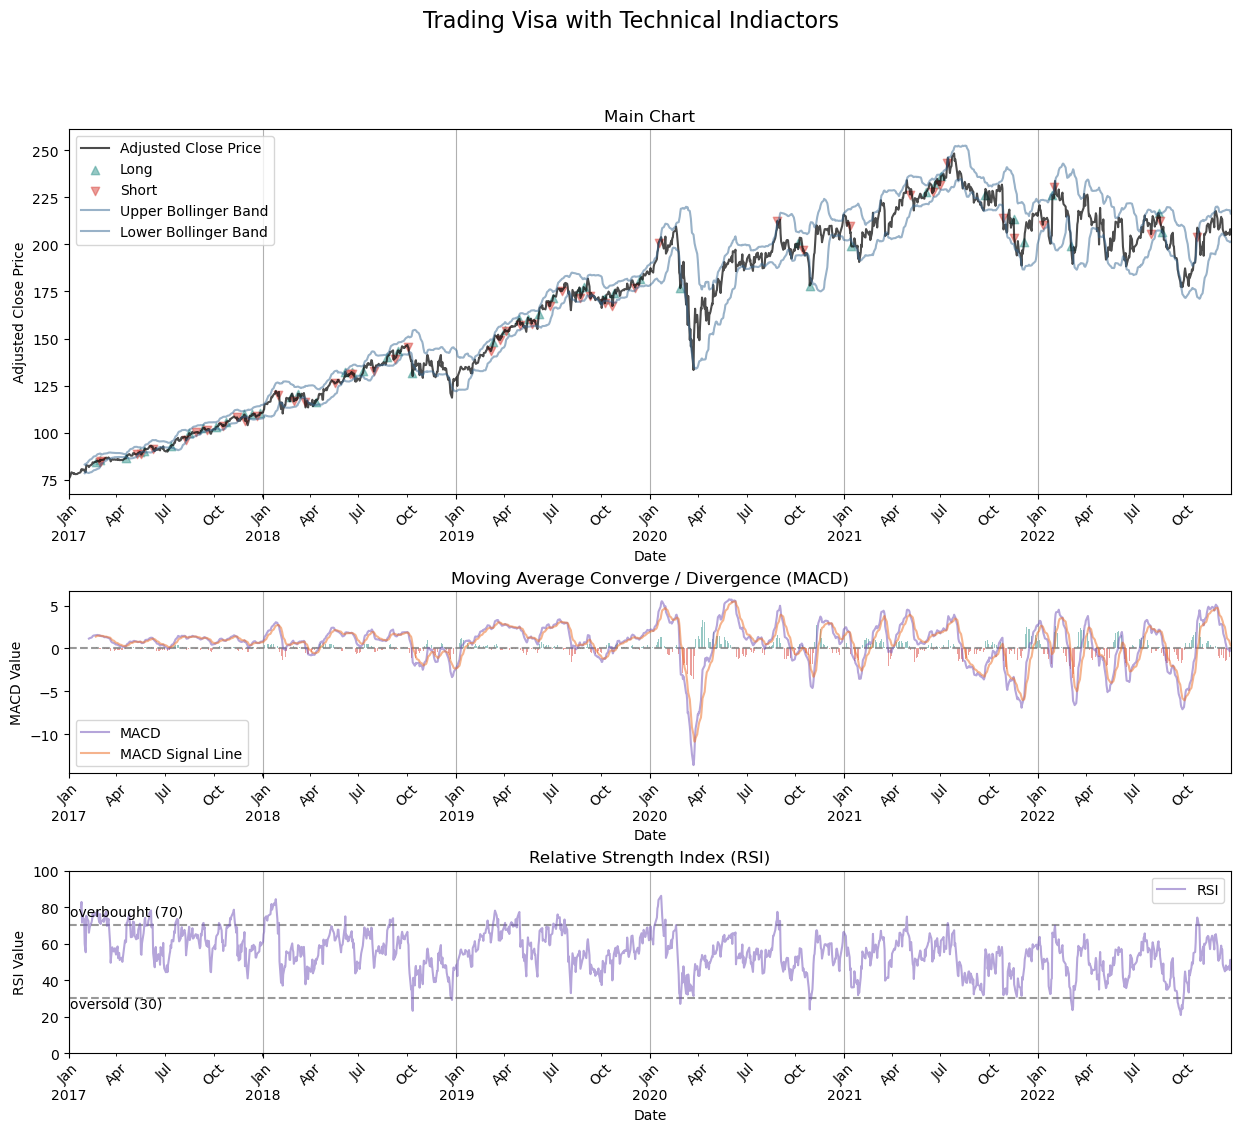

In [40]:
plot_trading()

## 7.2 Year 2017

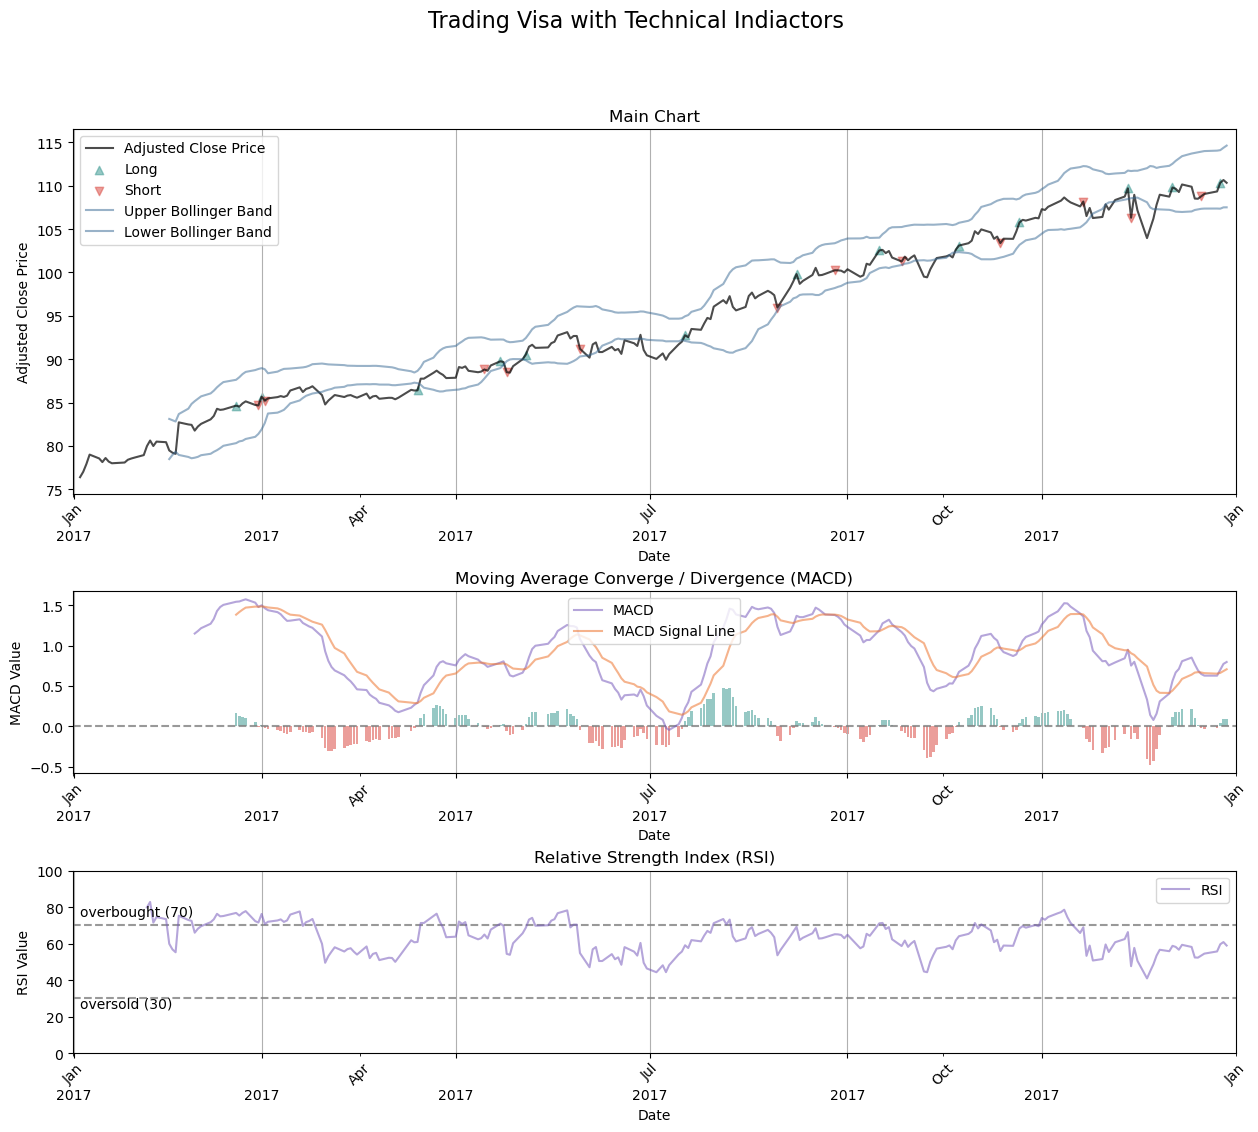

In [41]:
plot_trading(dt.datetime(2017, 1, 1), dt.datetime(2018, 1, 1))

## 7.3 Year 2018

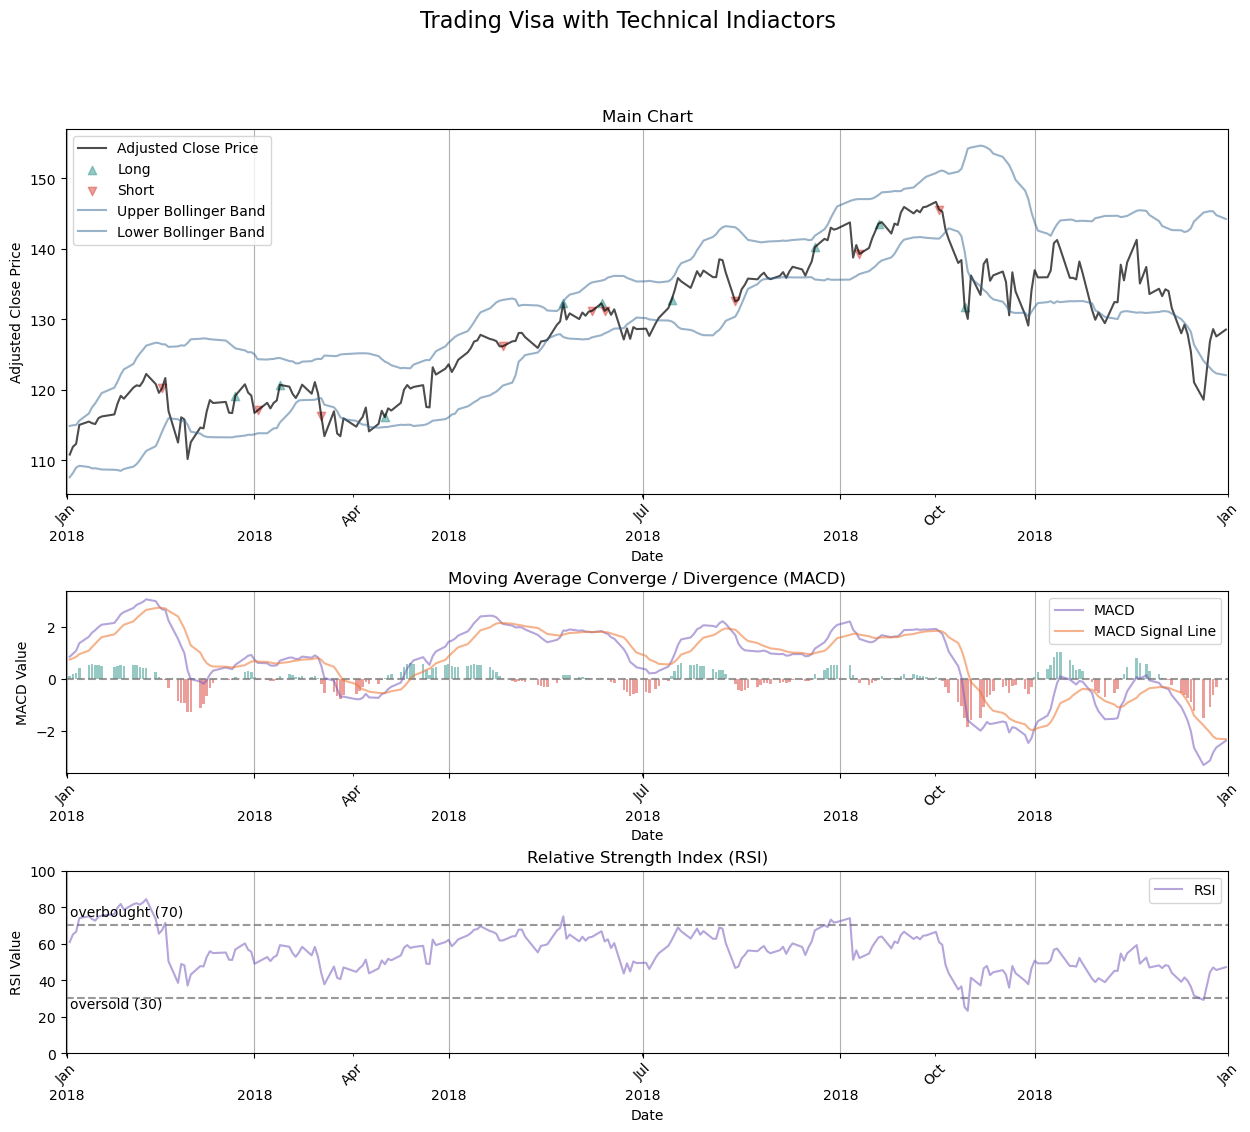

In [42]:
plot_trading(dt.datetime(2018, 1, 1), dt.datetime(2019, 1, 1))

## 7.4 Year 2019

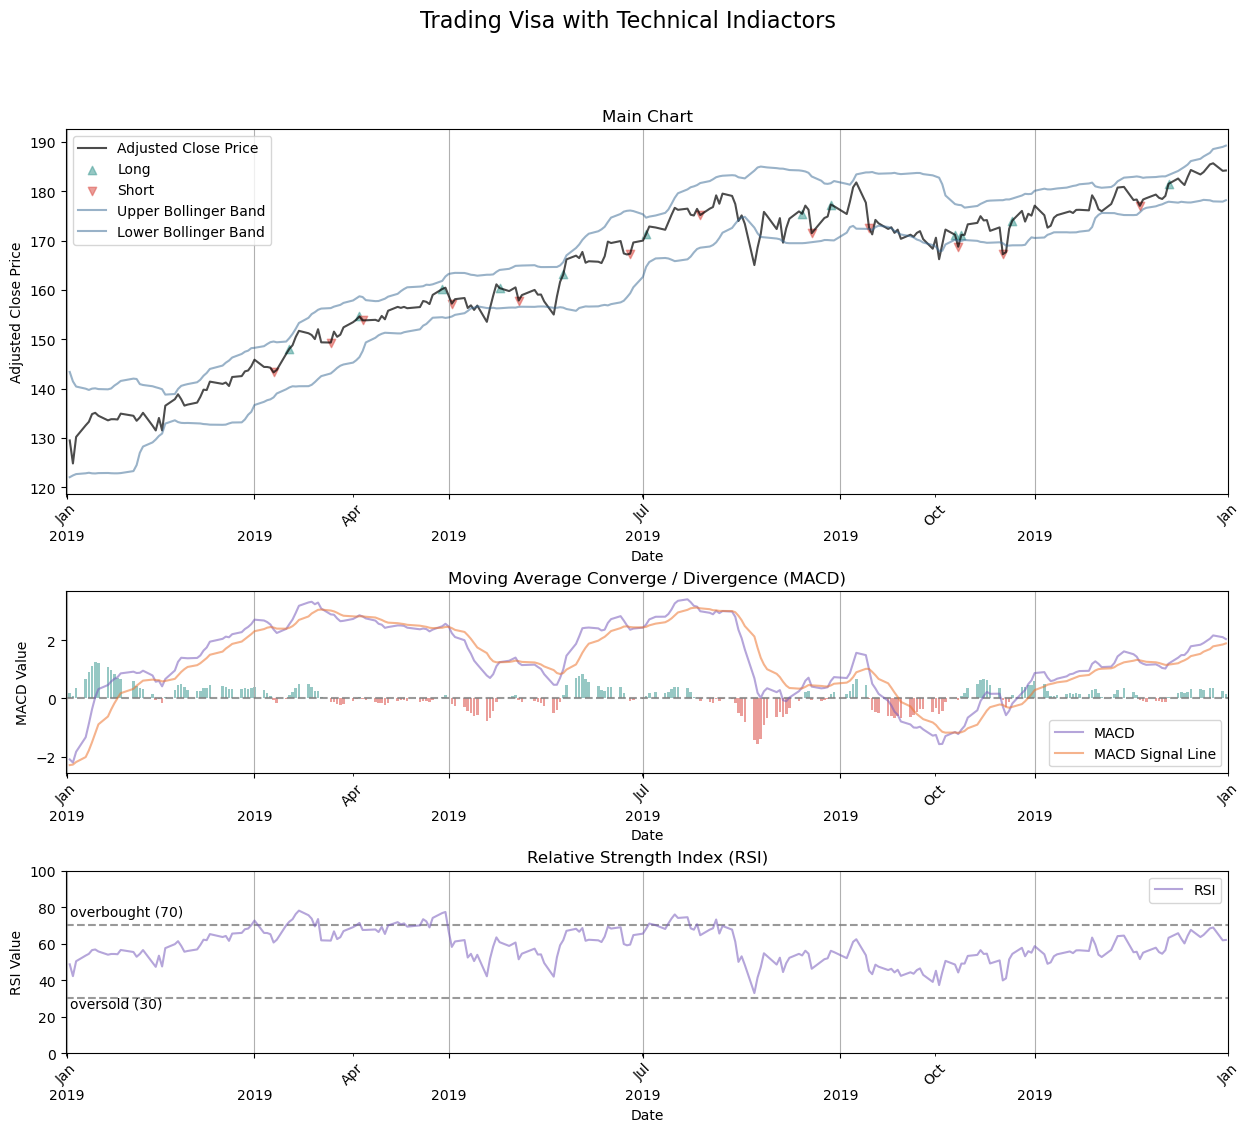

In [43]:
plot_trading(dt.datetime(2019, 1, 1), dt.datetime(2020, 1, 1))

## 7.5 Year 2020

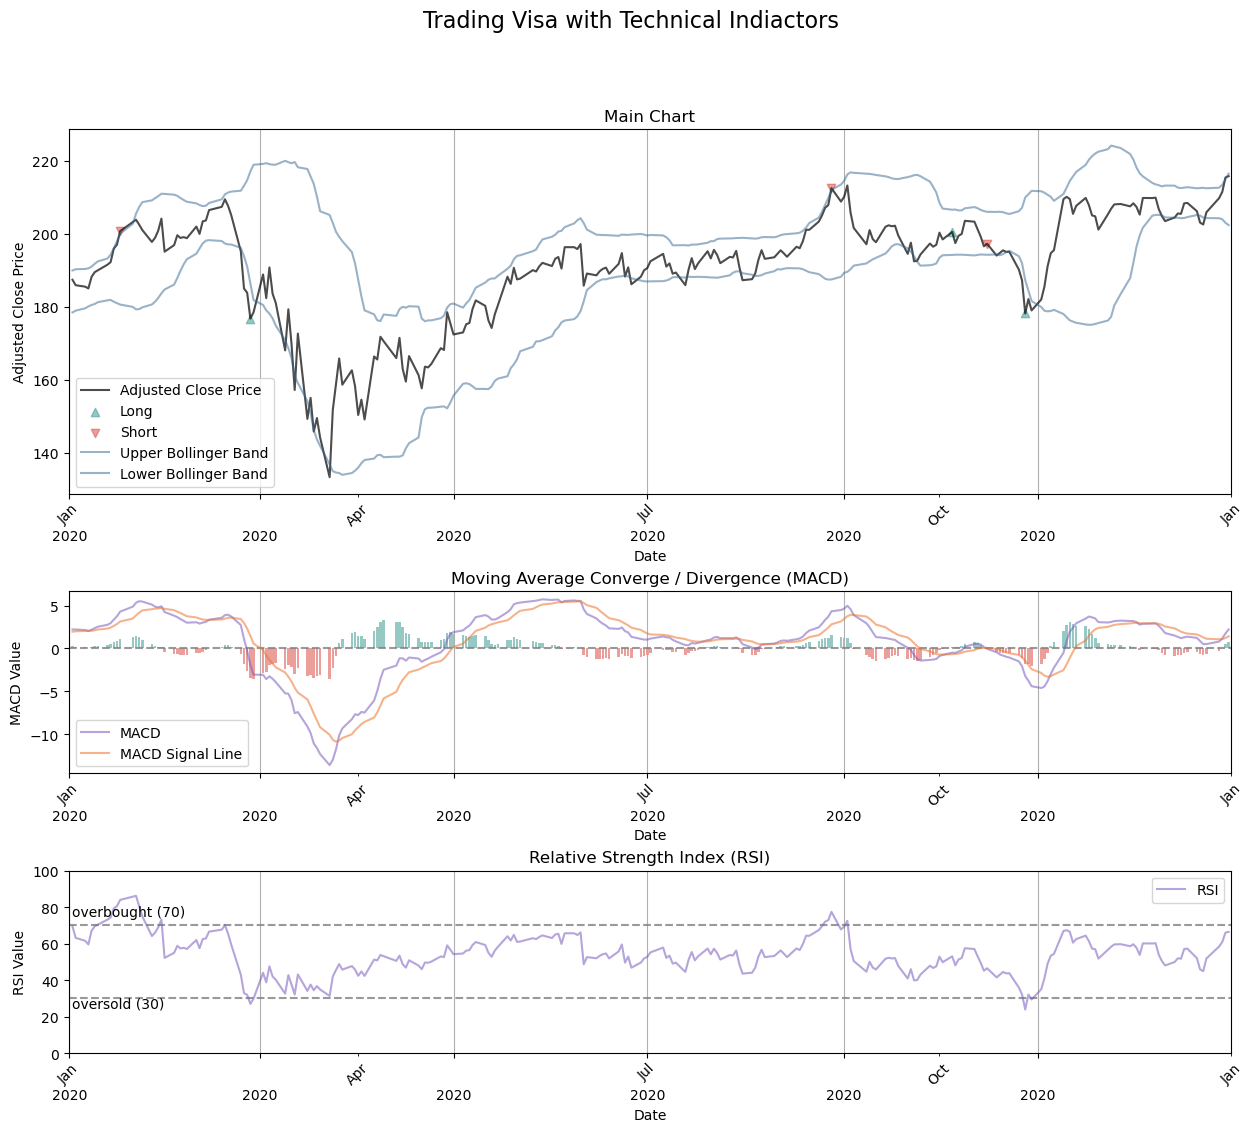

In [44]:
plot_trading(dt.datetime(2020, 1, 1), dt.datetime(2021, 1, 1))

## 7.6 Year 2021

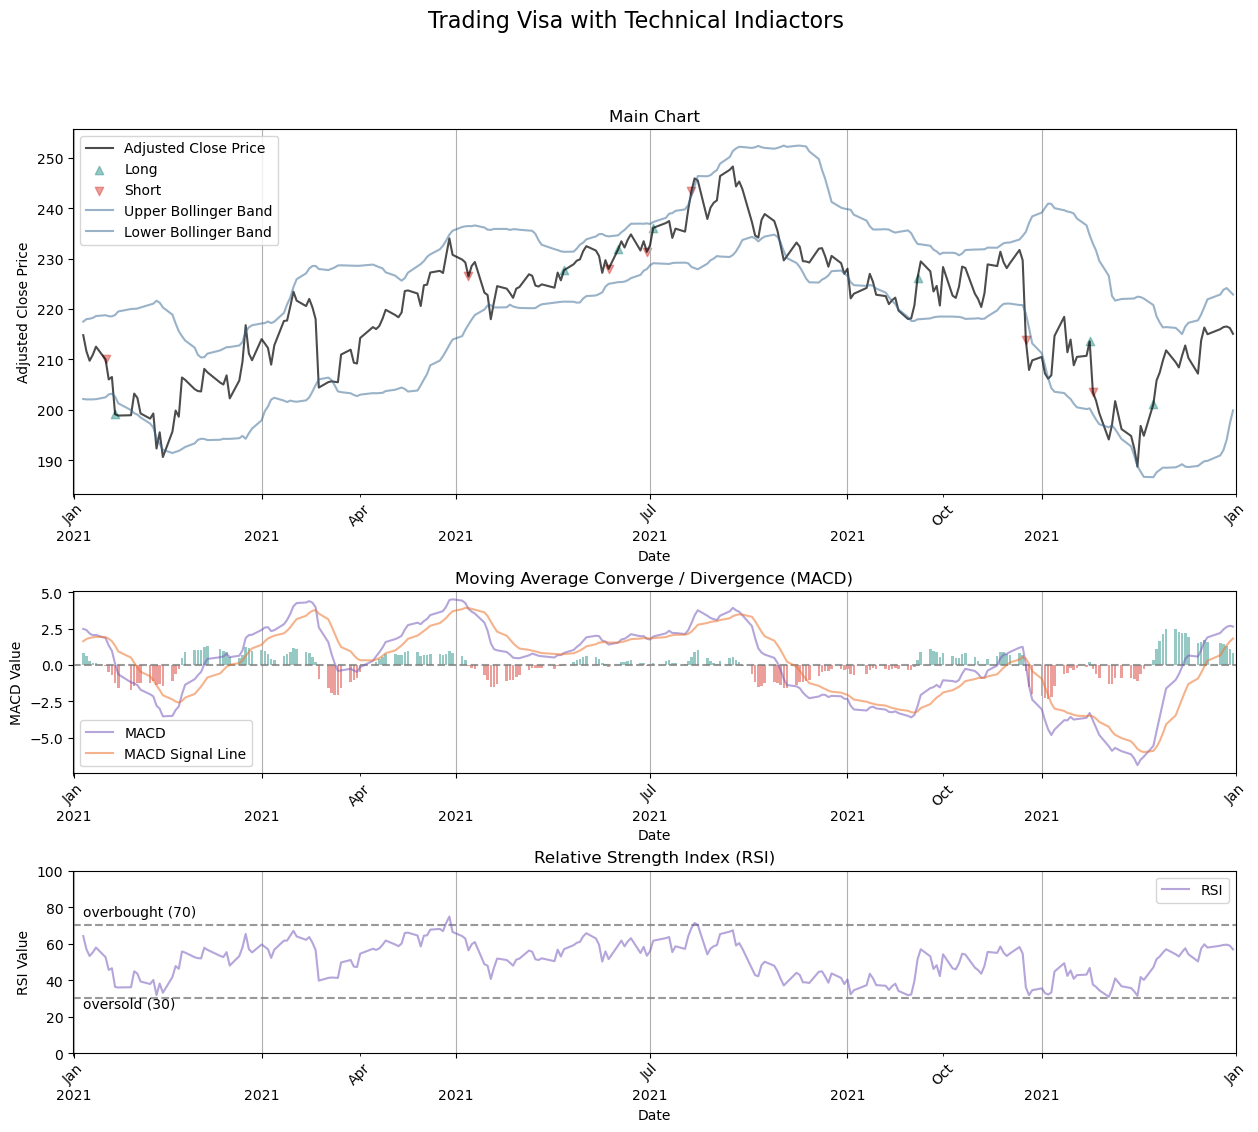

In [45]:
plot_trading(dt.datetime(2021, 1, 1), dt.datetime(2022, 1, 1))

## 7.7 Year 2022

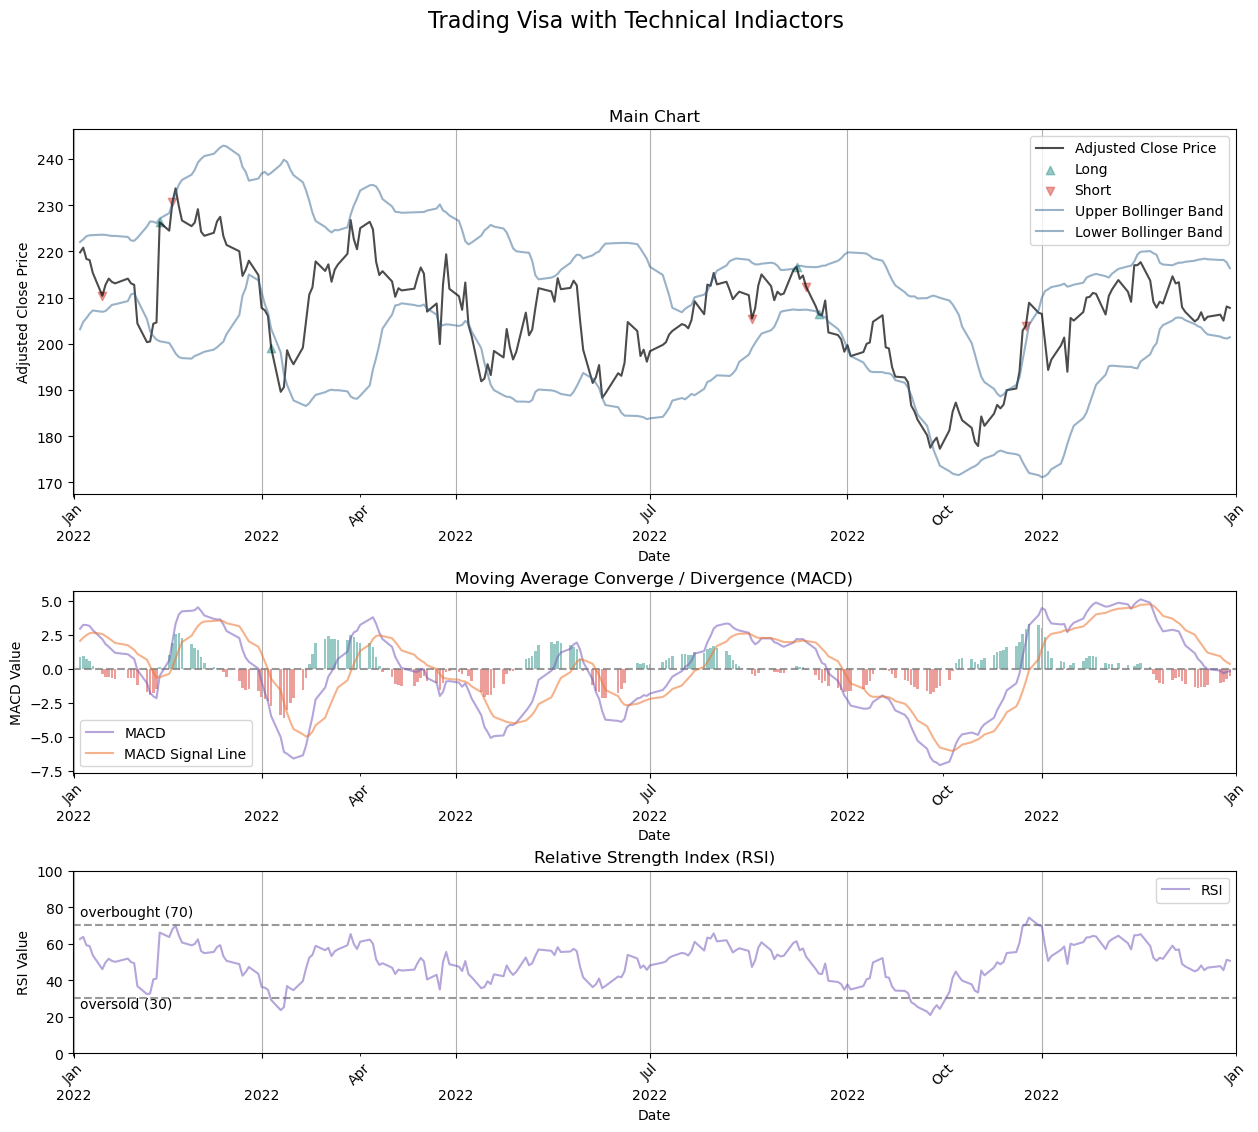

In [46]:
plot_trading(dt.datetime(2022, 1, 1), dt.datetime(2023, 1, 1))

# 8.0 Conclusion

In conclusion, our trading strategy based on MACD, RSI and Bollinger Band works well for VISA (Symbol: V). We backtest this strategy with past historical data from 2017-01-01 until 2022-12-12.

The annual return of this strategy is 33.47% and net return of 578.23%. We also beat the buy and hold return benchmark (171.97% return). The sharpe and sortino ratio of this strategy are 1.14 and 1.64 respestively. However, the annualised volatility and maximum drawdown are 27.45% and -69.23% respectively. This indicate this strategy is still risky as with such risky strategy, it may wipe out our portfolio for -69.23% before we start to profit anything. 

A fine-tuning on this strategy should be done to reduce the maximum-drawdown. A more rigious backtesting should be considered with event-driven backtest library such as 'bt'.